In [1]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
sns.set()

In [2]:
def load_sound(path):
    raw = []
    for fp in path:
        X, _ = librosa.load(fp)
        raw.append(X)
    return raw

def plot_waves(soundnames, raw):
    i = 1
    plt.figure(figsize = (20, 60))
    for n, f in zip(soundnames, raw):
        plt.subplot(10, 1, i)
        librosa.display.waveplot(np.array(f), sr = 22050)
        plt.title(n)
        i += 1
    plt.suptitle('Figure 1: Waveplot', x = 0.5, y = 0.915, fontsize = 18)
    plt.show()
    
def plot_specgram(soundnames, raw):
    i = 1
    fig = plt.figure(figsize = (25,60))
    for n, f in zip(soundnames, raw):
        plt.subplot(10, 1, i)
        plt.specgram(np.array(f), Fs = 22050)
        plt.title(n)
        i += 1
    plt.suptitle('Figure 1: Waveplot', x = 0.5, y = 0.915, fontsize = 18)
    plt.show()
    
def plot_logpower_specgram(soundnames, raw):
    i = 1
    plt.figure(figsize = (25, 60))
    for n, f in zip(soundnames, raw):
        plt.subplot(10, 1, i)
        D = librosa.logamplitude(np.abs(librosa.stft(f)) ** 2, ref_power = np.max)
        librosa.display.specshow(D, x_axis='time', y_axis = 'log')
        plt.title(n)
        i += 1
    plt.suptitle('Figure 1: Waveplot', x = 0.5, y = 0.915, fontsize = 18)
    plt.show()

In [3]:
dataset = pd.read_csv('/home/husein/space/UrbanSound8K/metadata/UrbanSound8K.csv')
dataset = dataset.iloc[np.random.permutation(len(dataset))]
dataset.head()

slice_file_name    fsID      start        end  salience  fold  \
2733  159751-8-0-10.wav  159751   6.150495  10.150495         2     4   
4105   178686-0-0-8.wav  178686   4.000000   8.000000         2     5   
2195   154758-5-0-9.wav  154758   4.500000   8.500000         1     4   
8204    82317-1-0-0.wav   82317  10.968053  14.968053         2     6   
5893    26184-5-2-0.wav   26184   8.581846   9.709976         1     5   

      classID            class  
2733        8            siren  
4105        0  air_conditioner  
2195        5    engine_idling  
8204        1         car_horn  
5893        5    engine_idling

In [4]:
unique_sound = np.unique(dataset.iloc[:, -1])
unique_sound

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype=object)

In [5]:
path = '/home/husein/space/UrbanSound8K/audio/fold'
location, names = [], []
for i in xrange(unique_sound.shape[0]):
    sound = dataset.loc[dataset['class'] == unique_sound[i]].iloc[0, :]
    location.append(path + str(sound['fold']) + '/' + str(sound['slice_file_name']))
    names.append(str(unique_sound[i]))
    
raw = load_sound(location)

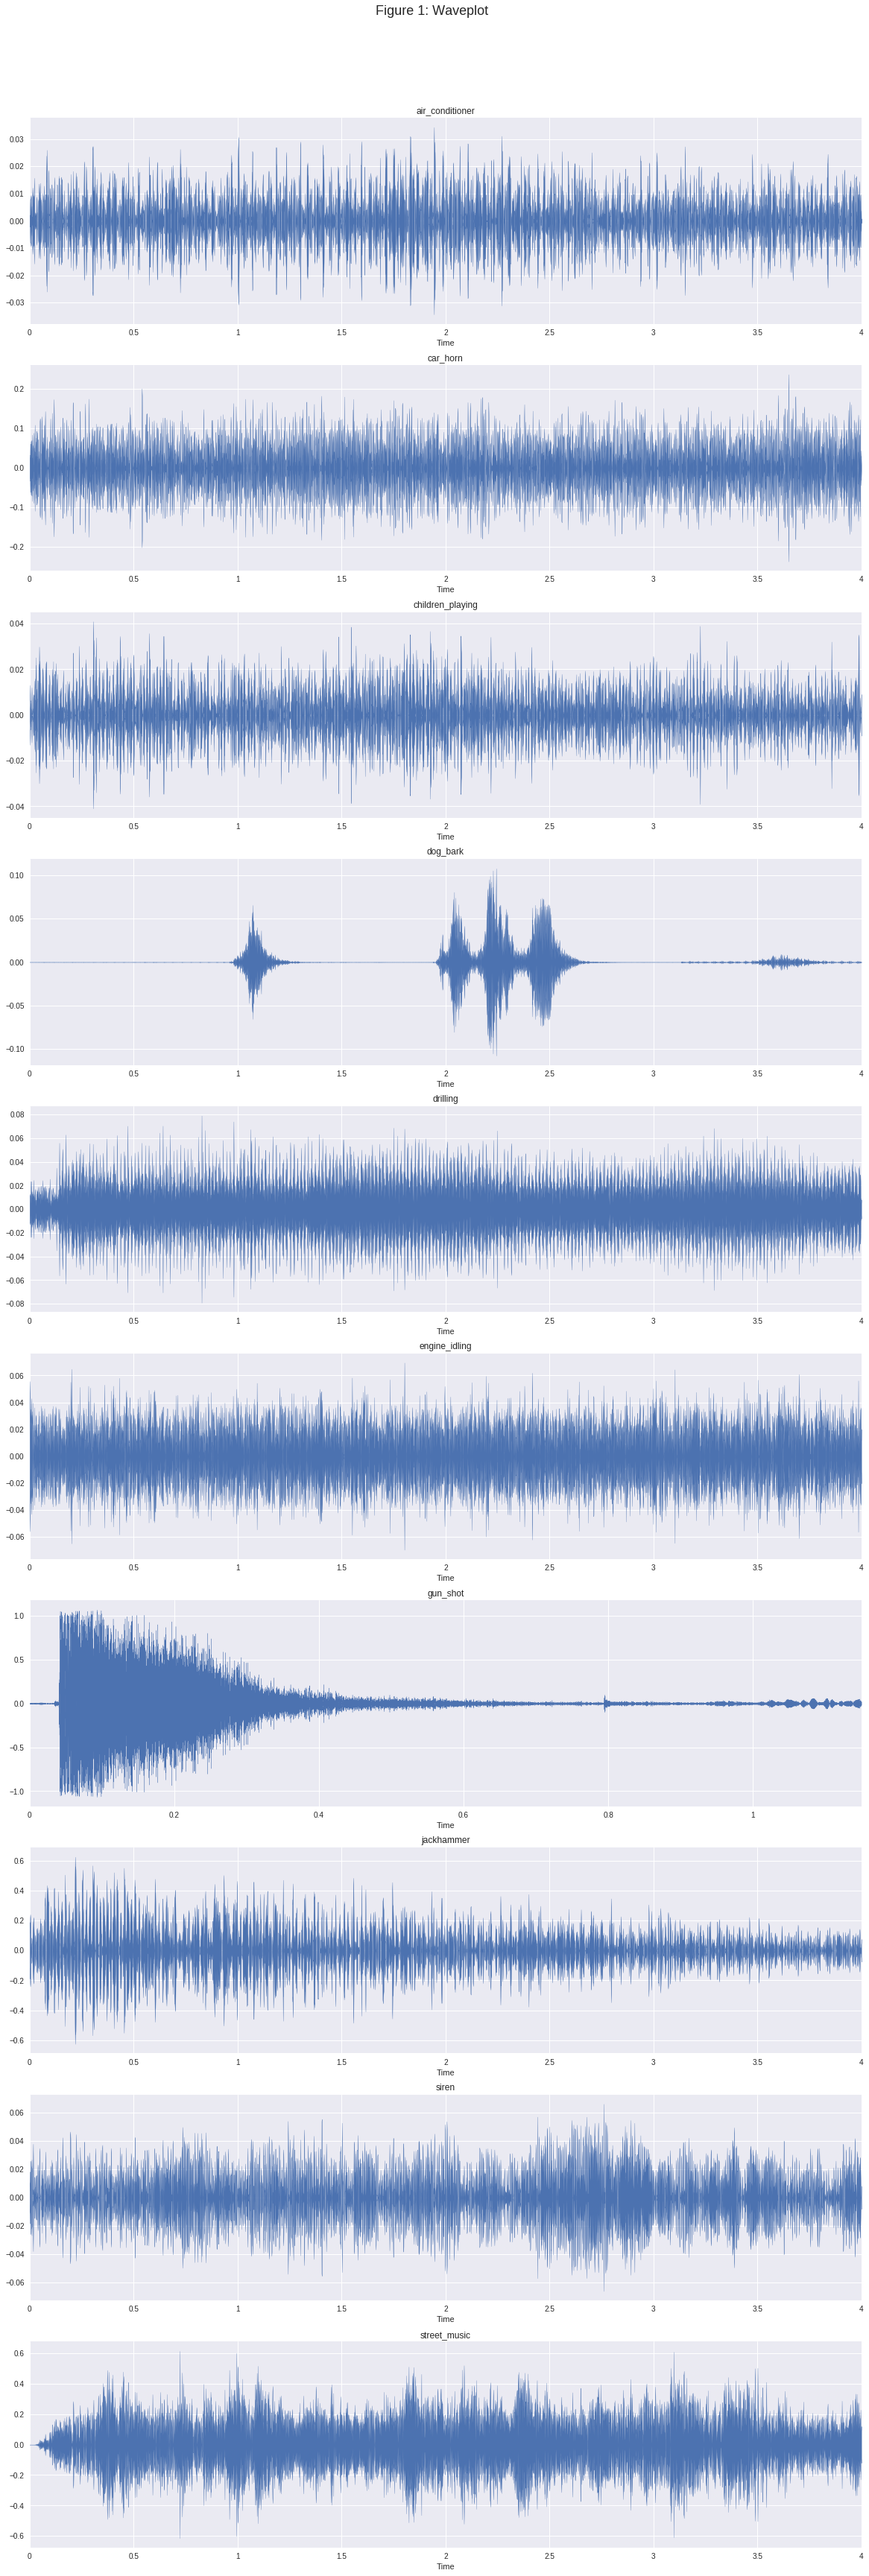

In [6]:
plot_waves(names, raw)

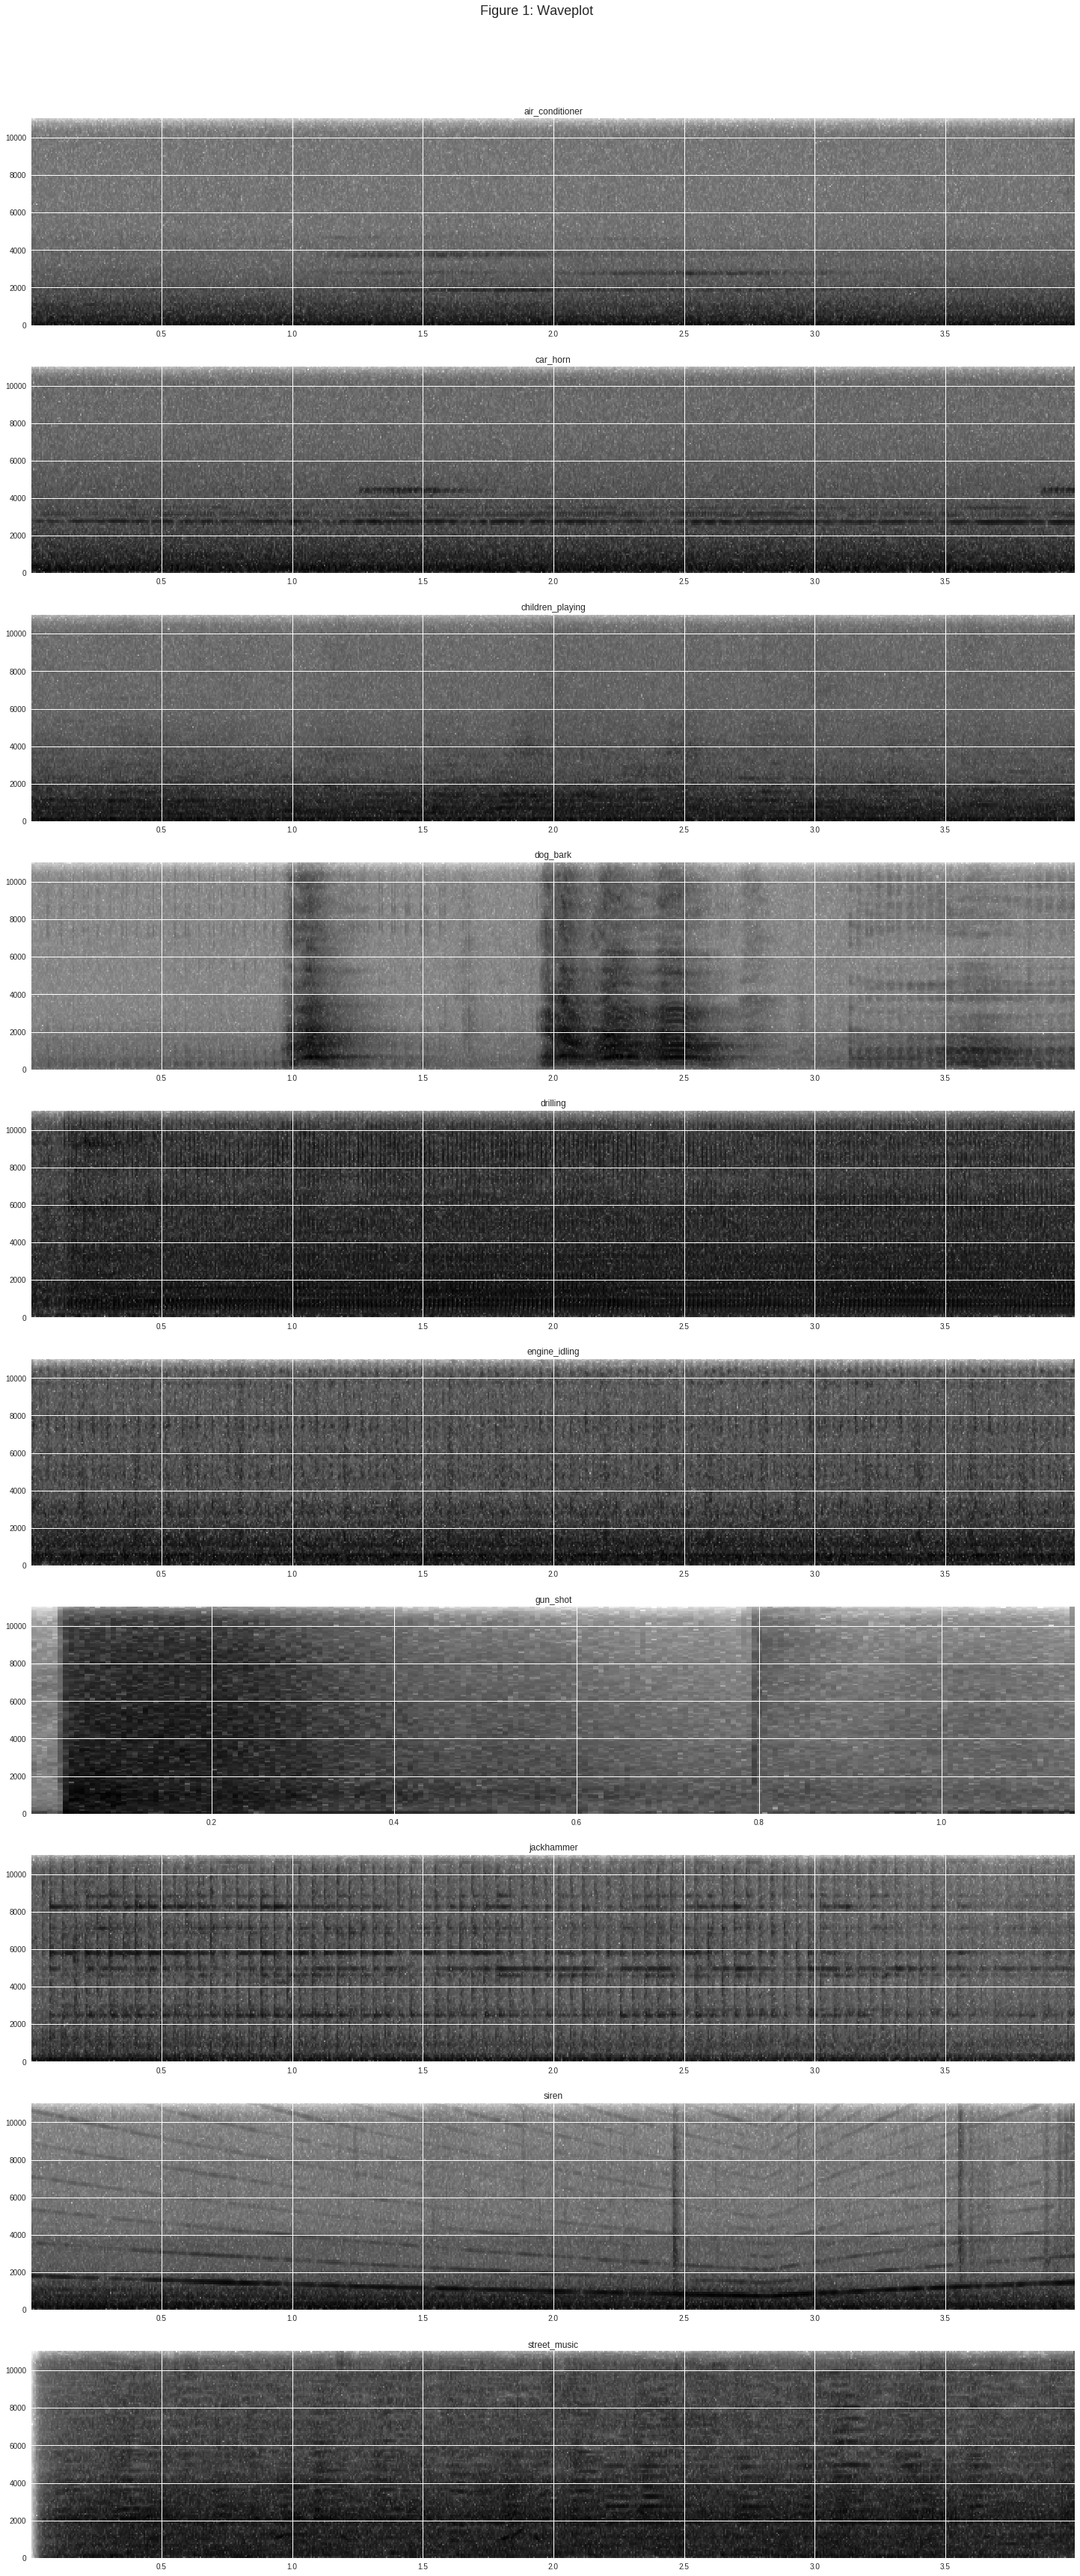

In [7]:
plot_specgram(names, raw)

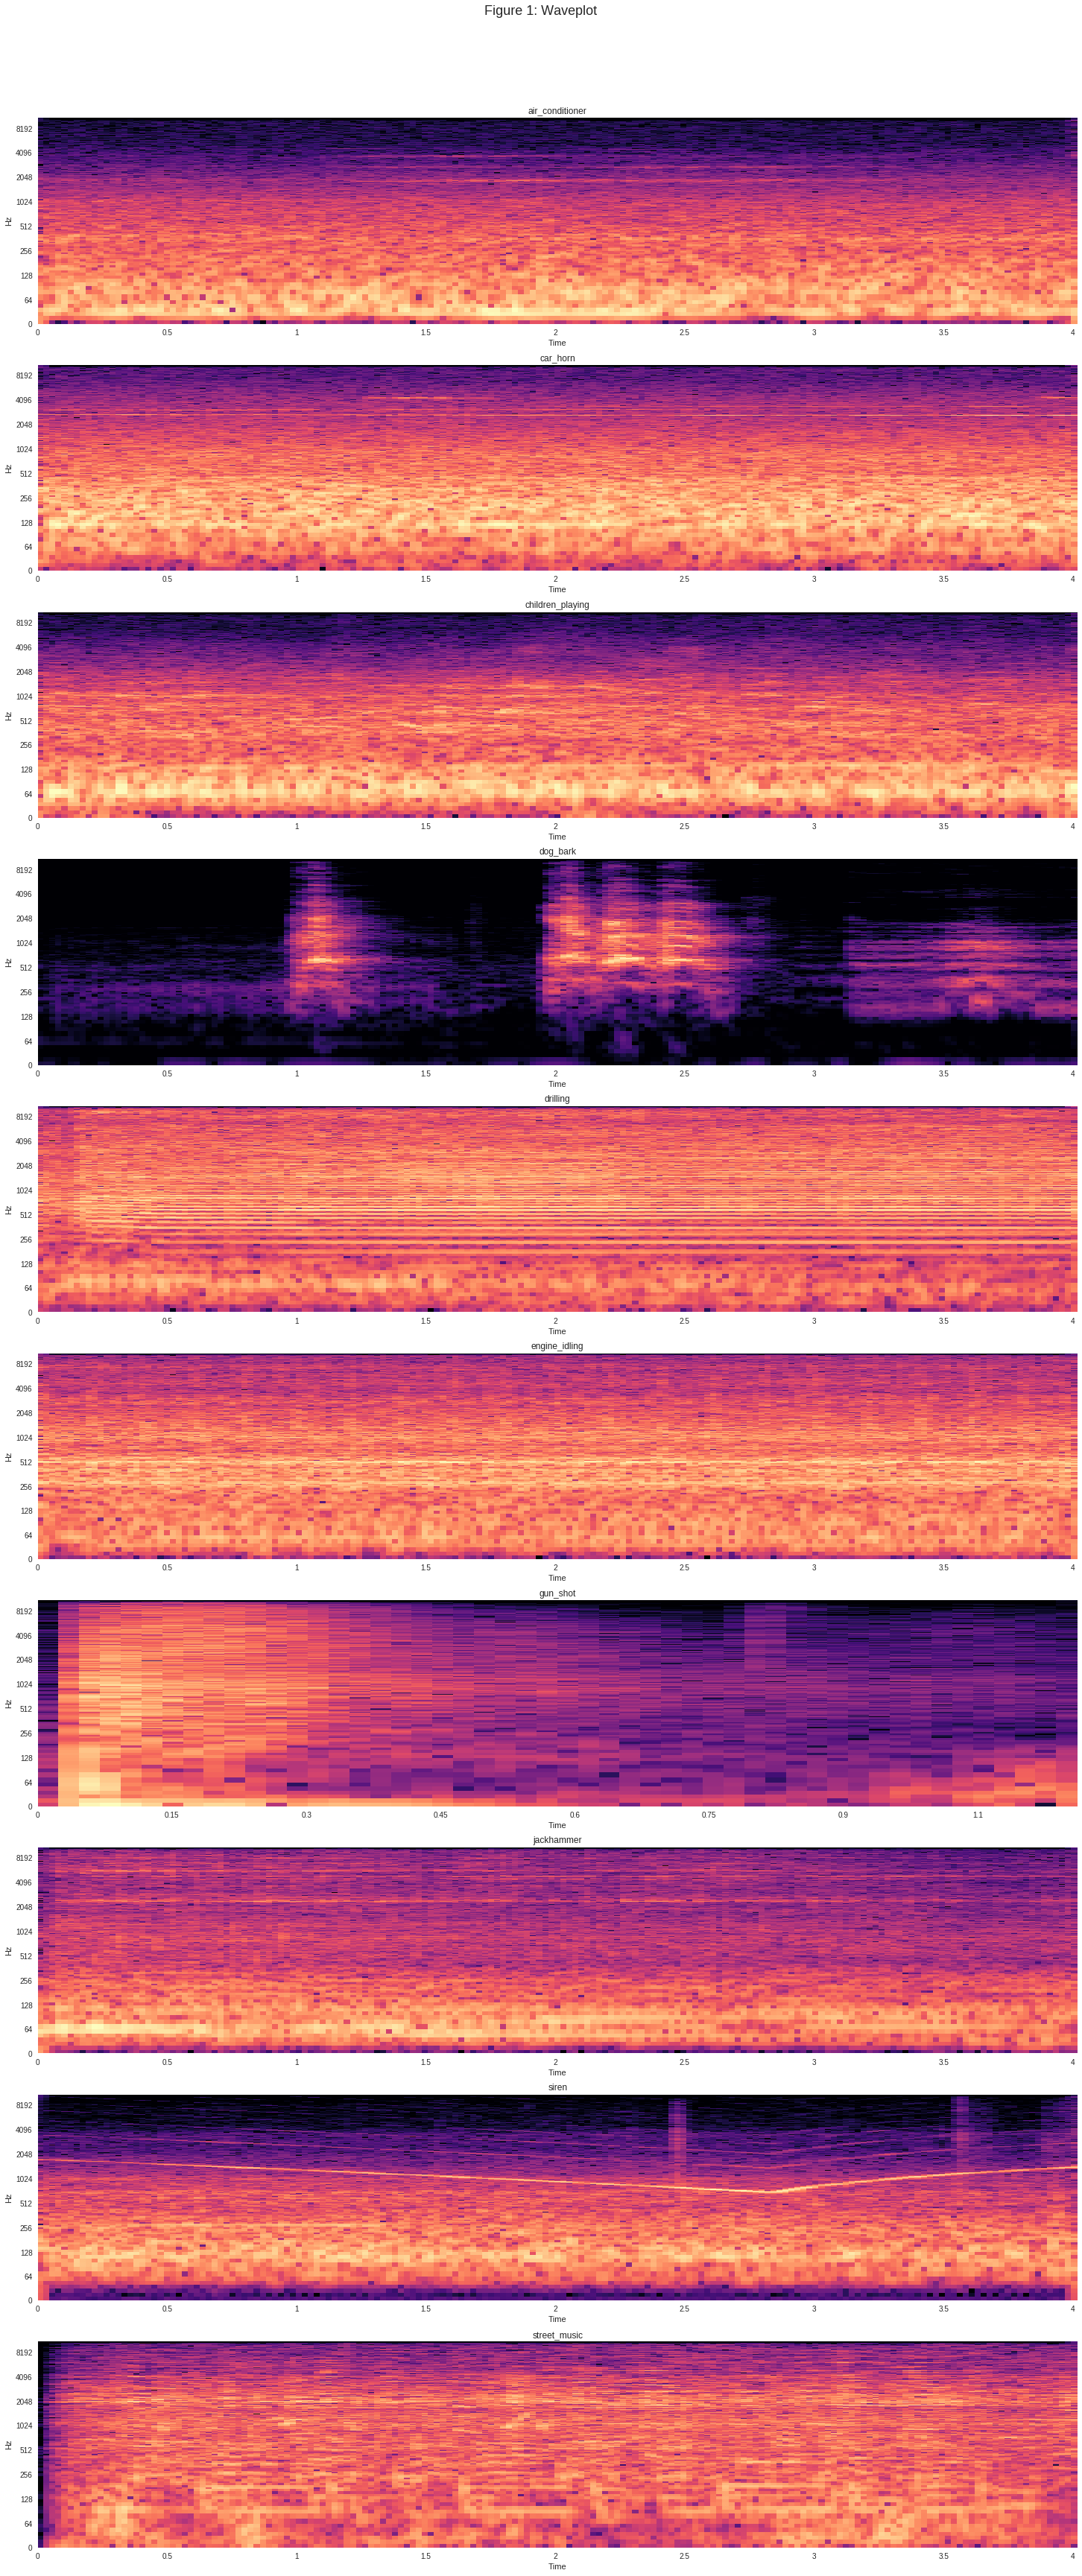

In [8]:
plot_logpower_specgram(names, raw)

In [9]:
def extract_feature(path):
    Y, sample_rate = librosa.load(path)
    stft = np.abs(librosa.stft(Y))
    mfcss = np.mean(librosa.feature.mfcc(y = Y, sr = sample_rate, n_mfcc = 40).T, axis = 0)
    chroma = np.mean(librosa.feature.chroma_stft(S = stft, sr = sample_rate).T, axis = 0)
    mel = np.mean(librosa.feature.melspectrogram(Y, sr = sample_rate).T, axis = 0)
    contrast = np.mean(librosa.feature.spectral_contrast(S = stft, sr = sample_rate).T, axis = 0)
    tonnetz = np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(Y), sr = sample_rate).T, axis = 0)
    return mfcss, chroma, mel, contrast, tonnetz

def detail_extract_feature(path):
    Y, sample_rate = librosa.load(path)
    stft = np.abs(librosa.stft(Y))
    print 'sample rate: ' + str(sample_rate)
    print 'sound shape: ' + str(Y.shape)
    print stft.shape
    print librosa.feature.mfcc(y = Y, sr = sample_rate, n_mfcc = 40).shape
    print librosa.feature.chroma_stft(S = stft, sr = sample_rate).shape
    print librosa.feature.melspectrogram(Y, sr = sample_rate).shape
    print librosa.feature.spectral_contrast(S = stft, sr = sample_rate).shape
    print librosa.feature.tonnetz(y = librosa.effects.harmonic(Y), sr = sample_rate).shape
    
def parse_audio_files(dataset, normalize = True):
    features, labels = np.empty((0, 193)), []
    dataset = dataset.ix[:, :].values
    for i in xrange(dataset.shape[0]):
        try:
            p = path + str(dataset[i, -3]) + '/' + str(dataset[i, 0])
            mfcss, chroma, mel, contrast, tonnetz = extract_feature(p)
            ext_features = np.hstack([mfcss, chroma, mel, contrast, tonnetz])
            features = np.vstack([features, ext_features])
            labels.append(int(dataset[i, -2]))
        except:
            print 'skipped: ' + str(dataset[i, :])
            continue
        
    if normalize:
        features = (features - features.min()) / (features.max() - features.min())
        
    return features, labels

def one_hot(labels, shape):
    onehot = np.zeros((len(labels), shape))
    for i in xrange(onehot.shape[0]):
        onehot[i, labels[i]] = 1.0
    return onehot
    
detail_extract_feature(location[0])

sample rate: 22050
sound shape: (88200,)
(1025, 173)
(40, 173)
(12, 173)
(128, 173)
(7, 173)
(6, 173)


In [10]:
class Model:
    def __init__(self, learning_rate, size_input, size_output, delta):
        self.X = tf.placeholder(tf.float32, (None, size_input))
        self.Y = tf.placeholder(tf.float32, (None, size_output))
        
        w1 = tf.Variable(tf.random_normal([size_input, 784], stddev = 0.5))
        b1 = tf.Variable(tf.random_normal([784], stddev = 0.1))
        
        w2 = tf.Variable(tf.random_normal([784, 256], stddev = 0.5))
        b2 = tf.Variable(tf.random_normal([256], stddev = 0.1))
        
        w3 = tf.Variable(tf.random_normal([256, 100], stddev = 0.5))
        b3 = tf.Variable(tf.random_normal([100], stddev = 0.1))
        
        w4 = tf.Variable(tf.random_normal([100, size_output], stddev = 0.5))
        b4 = tf.Variable(tf.random_normal([size_output], stddev = 0.1))
        
        hidden1 = tf.nn.relu(tf.matmul(self.X, w1) + b1)
        hidden1 = tf.layers.batch_normalization(hidden1)
        hidden1 = tf.nn.dropout(hidden1, 0.5)
        
        hidden2 = tf.nn.relu(tf.matmul(hidden1, w2) + b2)
        hidden2 = tf.layers.batch_normalization(hidden2)
        hidden2 = tf.nn.dropout(hidden2, 0.5)
        
        hidden3 = tf.nn.relu(tf.matmul(hidden2, w3) + b3)
        hidden3 = tf.layers.batch_normalization(hidden3)
        hidden3 = tf.nn.dropout(hidden3, 0.5)
        
        self.logits = tf.matmul(hidden3, w4) + b4
        
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.Y))
        self.cost += delta * tf.nn.l2_loss(w1) + delta * tf.nn.l2_loss(w2) + delta * tf.nn.l2_loss(w3) + delta * tf.nn.l2_loss(w4)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [ ]:
no_classes = np.unique(dataset['classID']).shape[0]
sess = tf.InteractiveSession()
model = Model(0.001, 193, no_classes, 0.00005)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())

train_dataset = dataset.iloc[:int(dataset.shape[0] * 0.80), :]
test_dataset = dataset.iloc[int(dataset.shape[0] * 0.80):, :]

In [ ]:
import time
from sklearn import metrics

EPOCH = 10
BATCH_SIZE = 128
ACCURACY, ACCURACY_TEST, LOST = [], [], []

for i in xrange(EPOCH):
    total_cost = 0; total_accuracy = 0; last_time = time.time()
    
    for x in xrange(0, (train_dataset.shape[0] // BATCH_SIZE) * BATCH_SIZE, BATCH_SIZE):
        print 'current batch: ' + str(x)
        features, labels = parse_audio_files(train_dataset.iloc[x : x + BATCH_SIZE, :])
        onehot = one_hot(labels, no_classes)
        
        loss, _ = sess.run([model.cost, model.optimizer], feed_dict = {model.X : features, model.Y : onehot})
        total_accuracy += sess.run(model.accuracy, feed_dict = {model.X : features, model.Y : onehot})
        total_cost += loss
        
    diff = time.time() - last_time
    total_accuracy /= (train_dataset.shape[0] // BATCH_SIZE)
    total_cost /= (train_dataset.shape[0] // BATCH_SIZE)
    ACCURACY.append(total_accuracy)
    LOST.append(total_cost)
    
    print "total accuracy during training: " + str(total_accuracy)
    print "epoch: " + str(i + 1) + ", loss: " + str(total_cost) + ", speed: " + str(diff / (train_dataset.shape[0] // BATCH_SIZE)) + " s / batch"
    
    features, labels = parse_audio_files(test_dataset)
    onehot = one_hot(labels, no_classes)
    accuracy_test = sess.run(model.accuracy, feed_dict = {model.X : features, model.Y : onehot})
    ACCURACY_TEST.append(accuracy_test)
    print "total accuracy during testing: " + str(accuracy_test)
    
    saver.save(sess, "./checkpoint/model.ckpt")
    
    if(i + 1) % 1 == 0:
        features, labels = parse_audio_files(test_dataset)
        logits = sess.run(tf.cast(tf.argmax(model.logits, 1), tf.int32), feed_dict = {model.X : features})
        print(metrics.classification_report(np.array(labels), logits, target_names = np.unique(dataset['class'])))

current batch: 0


/usr/local/lib/python2.7/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


current batch: 128
current batch: 256
current batch: 384
current batch: 512
current batch: 640
current batch: 768
current batch: 896
current batch: 1024
current batch: 1152
current batch: 1280
current batch: 1408
current batch: 1536
current batch: 1664
current batch: 1792
current batch: 1920
current batch: 2048
current batch: 2176
current batch: 2304
current batch: 2432
current batch: 2560
current batch: 2688
current batch: 2816
current batch: 2944
current batch: 3072
current batch: 3200
current batch: 3328
current batch: 3456
current batch: 3584
current batch: 3712
current batch: 3840
current batch: 3968
current batch: 4096
current batch: 4224
skipped: ['65745-3-0-21.wav' 65745 10.5 14.5 2 7 3 'dog_bark']
